<a href="https://colab.research.google.com/github/bhagyeshpm/darknet/blob/master/NLP_Project_Learner_Notebook_BhagyeshMukane.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Problem Statement**

### **Business Context**

In the dynamic landscape of the media and news industry, the ability to swiftly categorize and curate content has become a strategic imperative. The vast volume of information demands efficient systems to organize and present content to the audience.

The media industry, being the pulse of information dissemination, grapples with the continuous influx of news articles spanning diverse topics. Ensuring that the right articles reach the right audience promptly is not just a logistical necessity but a critical component in retaining and engaging audiences in an age of information overload.

Common Industry Challenges:
Amidst the ceaseless flow of news, organizations encounter challenges such as:
- Information Overload: The sheer volume of news articles makes manual categorization impractical.
- Timeliness: Delays in categorizing news articles can result in outdated or misplaced content.

### **Problem Definition**

E-news Express, a news aggregation startup, faces the challenge of categorizing the news articles collected. With news articles covering sports, busie=ness, politics, and more, the need for an advanced and automated system to categorize them has become increasingly evident. The manual efforts required for categorizing such a diverse range of news articles are substantial, and human errors in the categorization of news articles can lead to reputational damage for the startup. There is also the factor of delays and potential inaccuracies. To streamline and optimize this process, the organization recognizes the imperative of adopting cutting-edge technologies, particularly machine learning, to automate and enhance the categorization of content.

As a data scientist on the E-news Express data team, the task is to analyze the text in news articles and build a model for categorizing them. The goal is to optimize the categorization process, ensuring timely and personalized delivery.

### **Data Dictionary**

- **Article**: The main body of the news article
- **Category**: The category the article belongs to

## **Please read the instructions carefully before starting the project.**

This is a commented Python Notebook file in which all the instructions and tasks to be performed are mentioned.
* Blanks '_______' are provided in the notebook that
needs to be filled with an appropriate code to get the correct result. With every '_______' blank, there is a comment that briefly describes what needs to be filled in the blank space.
* Identify the task to be performed correctly, and only then proceed to write the required code.
* Please run the codes in a sequential manner from the beginning to avoid any unnecessary errors.
* Add the results/observations (wherever mentioned) derived from the analysis in the presentation and submit the same. Any mathematical or computational details which are a graded part of the project can be included in the Appendix section of the presentation.

**Note**:
1. Please make sure to use Google Colab for this project.
2. Please set the Colab runtime to **T4 GPU** before starting the project.

## **Installing and Importing Necessary Libraries and Dependencies**

In [1]:
# installing the libraries for transformers
!pip install -U -q sentence-transformers transformers bitsandbytes accelerate sentencepiece

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('max_colwidth', None)

import torch
from sentence_transformers import SentenceTransformer
from transformers import T5Tokenizer, T5ForConditionalGeneration, pipeline
# To build a Random Forest model
from sklearn.ensemble import RandomForestClassifier

import pickle
# to split the data
from sklearn.model_selection import train_test_split
# to compute performance metrics
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score,make_scorer,recall_score,precision_score,f1_score
from sklearn.model_selection import GridSearchCV


# to ignore unnecessary warnings
import warnings
warnings.filterwarnings("ignore")

## **Loading the Dataset**

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Complete the code to read the CSV file
data = pd.read_csv("/content/drive/MyDrive/Saved from Chrome/article_data.csv")

## **Data Overview**

In [5]:
# Display the first 5 rows of the dataset
data.head()

,Article,Category
0,"Sudan Govt rejects call to separate religion, state Sudanese rebel leaders #39; demand that Islam be kept out of government in the war-torn region of Darfur, has been rejected by government negotiators.",0
1,Hassan: #39;Abhorrent act #39; says Blair Western political leaders have united to condemn the kidnappers of charity worker Margaret Hassan after a video surfaced apparently showing a militant firing a pistol into the head of a blindfolded woman wearing an orange jumpsuit.,0
2,"Sharon Says Gaza Evacuation Set for 2005 (AP) AP - Israel's evacuation of the Gaza Strip will begin next summer and will take about 12 weeks, Prime Minister Ariel Sharon said Wednesday, reversing an earlier decision to speed up the pullout.",0
3,"Prince Charles chastised for quot;old fashioned quot; views A minister has launched a scathing attack on heir to the throne Prince Charles, accusing him of being quot;very old fashioned quot; and out of touch in his views on teaching in schools.",0
4,"U.S. Says N.Korea Blast Probably Not Nuclear SEOUL (Reuters) - A huge explosion rocked North Korea last week but U.S. and South Korean officials said on Sunday it was unlikely to have been a nuclear weapons test despite the appearance of a ""peculiar cloud"" over the area.",0


In [6]:
# Display information about the dataset
print("Dataset Information:")
data.info()

# Check for missing values
print("\nMissing Values:")
print(data.isnull().sum())

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Article   4000 non-null   object
 1   Category  4000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 62.6+ KB

Missing Values:
Article     0
Category    0
dtype: int64


In [7]:
# Display the distribution of categories
print("Category Distribution:")
print(data['Category'].value_counts())

Category Distribution:
Category
0    1000
1    1000
2    1000
3    1000
Name: count, dtype: int64


## **Exploratory Data Analysis (EDA)**


In [8]:
 # function to create labeled barplots

def labeled_barplot(data, feature, perc=False, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 1, 5))
    else:
        plt.figure(figsize=(n + 1, 5))

    plt.xticks(rotation=90, fontsize=15)
    ax = sns.countplot(
        data=data,
        x=feature,
        palette="Paired",
        order=data[feature].value_counts().index[:n].sort_values(),
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage

    plt.show()  # show the plot

#### Distribution of category

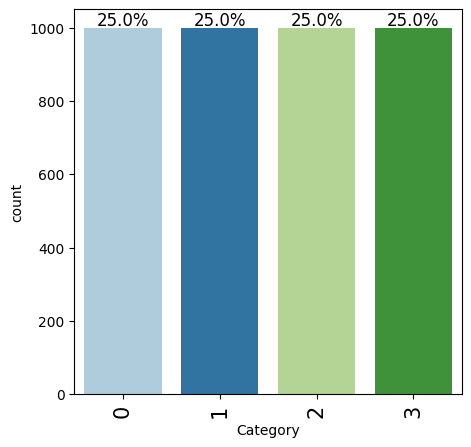

In [9]:
# Complete the code to get the barplot of the category variable
labeled_barplot(data, feature='Category', perc=True)

## **Model Building - Sentence Transformer + ML**

### Defining the SentenceTransformer Model

In [10]:
## Defining the model.
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

In [11]:
def confusion_matrix_sklearn(model, predictors, target):
    """
    To plot the confusion_matrix with percentages

    model: classifier
    predictors: independent variables
    target: dependent variable
    """
    y_pred = model.predict(predictors)
    cm = confusion_matrix(target, y_pred)
    labels = np.asarray(
        [
            ["{0:0.0f}".format(item) + "\n{0:.2%}".format(item / cm.flatten().sum())]
            for item in cm.flatten()
        ]
    ).reshape(cm.shape[0], cm.shape[1])

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=labels, fmt="")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

### Encoding the data

In [12]:
# setting the compute device
device = "cuda" if torch.cuda.is_available() else "cpu"

## Encoding the dataset.
embedding_matrix = model.encode(data["Article"],show_progress_bar=True,device=device)

Batches:   0%|          | 0/125 [00:00<?, ?it/s]

### Train-Test Split

In [13]:
# Split the data
X = embedding_matrix
y = data["Category"]

In [14]:
# Initial split into training (80%) and testing (20%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.20, random_state=42)

# Further split the temporary set into validation (10%) and test (10%) sets
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42)

In [15]:
print("Shape of the set of input variables for training:", X_train.shape)    # Training input data
print("Shape of the set of input variables for validation:", X_valid.shape)  # Validation input data
print("Shape of the set of input variables for testing:", X_test.shape)      # Testing input data

Shape of the set of input variables for training: (3200, 384)
Shape of the set of input variables for validation: (400, 384)
Shape of the set of input variables for testing: (400, 384)


In [16]:
print("Shape of the set of output variables for training:", y_train.shape)    # Training output data
print("Shape of the set of output variables for validation:", y_valid.shape)  # Validation output data
print("Shape of the set of output variables for testing:", y_test.shape)      # Testing output data

Shape of the set of output variables for training: (3200,)
Shape of the set of output variables for validation: (400,)
Shape of the set of output variables for testing: (400,)


### Random Forest Model (base)

In [17]:
# defining a function to compute different metrics to check performance of a classification model built using sklearn

def model_performance_classification_sklearn(model, predictors, target):
    """
    Function to compute different metrics to check classification model performance

    model: classifier
    predictors: independent variables
    target: dependent variable
    """

    # predicting using the independent variables
    pred = model.predict(predictors)

    acc = accuracy_score(target, pred)  # to compute Accuracy
    recall = recall_score(target, pred,average="weighted")  # to compute Recall
    precision = precision_score(target, pred,average="weighted")  # to compute Precision
    f1 = f1_score(target, pred,average="weighted")  # to compute F1-score

    # creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {"Accuracy": acc, "Recall": recall, "Precision": precision, "F1": f1,},
        index=[0],
    )

    return df_perf

In [18]:
## Building the model
rf = RandomForestClassifier(random_state = 42)

## The code to fit the model on X_train and y_train
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

**Confusion Matrix**

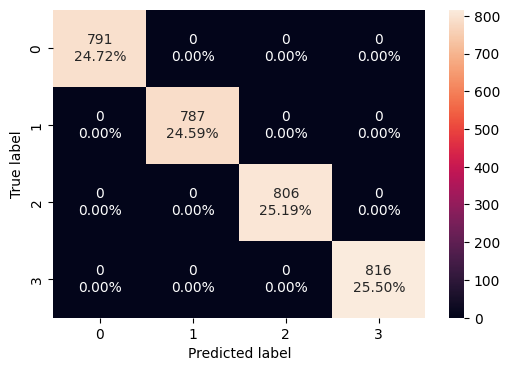

In [19]:
## To get the confusion matrix on X_train and y_train
confusion_matrix_sklearn(rf, X_train, y_train)

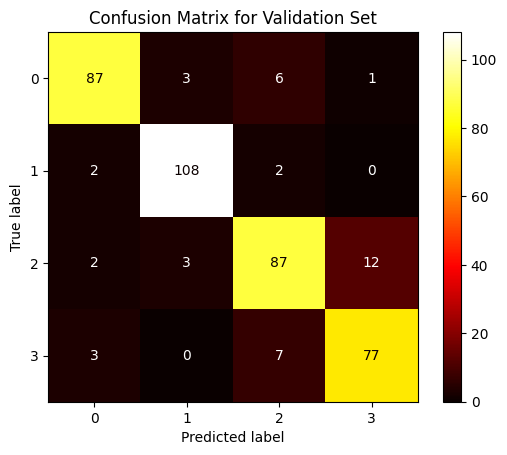

In [20]:
## Write the code to get the confusion matrix for X_valid and y_valid

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Get predictions for the validation set
y_valid_pred = rf.predict(X_valid)

# Compute the confusion matrix
cm_valid = confusion_matrix(y_valid, y_valid_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm_valid, display_labels=rf.classes_)
disp.plot(cmap="hot")

# Show the plot
plt.title("Confusion Matrix for Validation Set")
plt.show()

In [21]:
# Predicting on train data
y_pred_train = rf.predict(X_train)

# Predicting on validation data
y_pred_valid = rf.predict(X_valid)

**Classification report**

In [22]:
## Classification report for train data
print(classification_report(y_train, y_pred_train))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       791
           1       1.00      1.00      1.00       787
           2       1.00      1.00      1.00       806
           3       1.00      1.00      1.00       816

    accuracy                           1.00      3200
   macro avg       1.00      1.00      1.00      3200
weighted avg       1.00      1.00      1.00      3200



In [23]:
## Write the code to get the classification report for validation data

from sklearn.metrics import classification_report

# Predict on the validation data
y_valid_pred = rf.predict(X_valid)

# Generate the classification report
print("Classification Report for Validation Data:\n")
print(classification_report(y_valid, y_valid_pred))

Classification Report for Validation Data:

              precision    recall  f1-score   support

           0       0.93      0.90      0.91        97
           1       0.95      0.96      0.96       112
           2       0.85      0.84      0.84       104
           3       0.86      0.89      0.87        87

    accuracy                           0.90       400
   macro avg       0.90      0.90      0.90       400
weighted avg       0.90      0.90      0.90       400



In [24]:
## Storing the metrics
rf_train_perf = model_performance_classification_sklearn(
    rf, X_train, y_train
)

In [25]:
## Storing the metrics
rf_valid_perf = model_performance_classification_sklearn(
    rf, X_valid, y_valid
)

### Random Forest (with class_weights)

In [26]:
## Building the model
rf_balanced = RandomForestClassifier(class_weight="balanced", random_state=42)

## Complete the code to fit the model on X_train and y_train
rf_balanced.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

**Confusion Matrix**

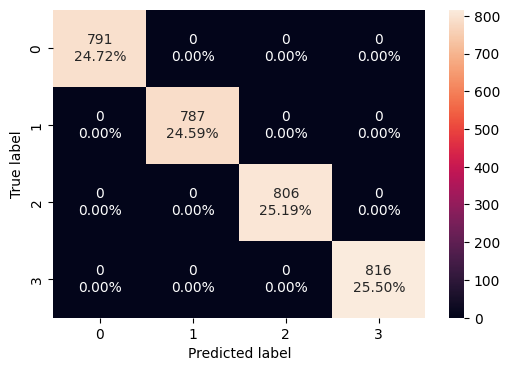

In [27]:
## To get the confusion matrix on X_train and y_train
confusion_matrix_sklearn(rf_balanced, X_train, y_train)

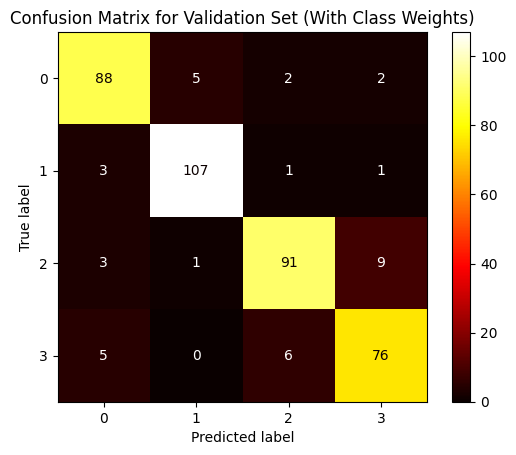

In [28]:
## Write the code to get the confusion matrix for X_valid and y_valid

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Get predictions for the validation data using the class-weighted model
y_valid_pred_balanced = rf_balanced.predict(X_valid)

# Compute the confusion matrix
cm_valid_balanced = confusion_matrix(y_valid, y_valid_pred_balanced)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm_valid_balanced, display_labels=rf_balanced.classes_)
disp.plot(cmap="hot")

# Show the plot
plt.title("Confusion Matrix for Validation Set (With Class Weights)")
plt.show()

In [29]:
## Predicting on train data
y_pred_train = rf_balanced.predict(X_train)

## Complete the code to predict the model on X_valid
y_pred_valid = rf_balanced.predict(X_valid)

**Classification report**

In [30]:
## Classification report for train data
print(classification_report(y_train, y_pred_train))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       791
           1       1.00      1.00      1.00       787
           2       1.00      1.00      1.00       806
           3       1.00      1.00      1.00       816

    accuracy                           1.00      3200
   macro avg       1.00      1.00      1.00      3200
weighted avg       1.00      1.00      1.00      3200



In [31]:
## Write the code to get the classification report for validation data

from sklearn.metrics import classification_report

# Generate the classification report for validation data
print("Classification Report for Validation Data:\n")
print(classification_report(y_valid, y_pred_valid))

Classification Report for Validation Data:

              precision    recall  f1-score   support

           0       0.89      0.91      0.90        97
           1       0.95      0.96      0.95       112
           2       0.91      0.88      0.89       104
           3       0.86      0.87      0.87        87

    accuracy                           0.91       400
   macro avg       0.90      0.90      0.90       400
weighted avg       0.91      0.91      0.90       400



In [32]:
## Storing the metrics
rf_bal_train_perf = model_performance_classification_sklearn(
    rf_balanced, X_train, y_train
)

In [33]:
## Complete the code to store the metrics of validation data
rf_bal_valid_perf = model_performance_classification_sklearn(
    rf_balanced, X_valid, y_valid
)

### Random Forest (with hyperparamter tuning)

In [34]:
## Building the model
rf_tuned = RandomForestClassifier(class_weight="balanced", random_state=42)

## Defining the hyperparameter grid for tuning
parameters = {
    "max_depth": list(np.arange(4, 10, 3)),
    "max_features": ["sqrt", 0.5, 0.7],
    "min_samples_split": [5, 6],
    "n_estimators": np.arange(30, 110, 15),
}

## Defining the type of scoring used to compare parameter combinations
## We need to specify the mechanism of averaging as we have more than 2 target classes
scorer = make_scorer(recall_score, average='weighted')

## Running the grid search
grid_obj = GridSearchCV(rf_tuned, parameters, scoring=scorer, cv=3, n_jobs=-1)

## Complete the code to fit the model on X_train and y_train
grid_obj = grid_obj.fit( X_train, y_train)

In [35]:
## Creating a new model with the best combination of parameters
rf_tuned = grid_obj.best_estimator_

## Complte the code to fit the new model to X_train and y_train
rf_tuned.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=7,
                       min_samples_split=6, n_estimators=105, random_state=42)

**Confusion Matrix**

In [36]:
## Write the code to get the classification report for train data

from sklearn.metrics import classification_report

# Predict on the training data
y_train_pred = rf_tuned.predict(X_train)

# Generate the classification report
print("Classification Report for Training Data (Tuned Model):\n")
print(classification_report(y_train, y_train_pred))

Classification Report for Training Data (Tuned Model):

              precision    recall  f1-score   support

           0       0.98      0.94      0.96       791
           1       0.97      1.00      0.98       787
           2       0.95      0.95      0.95       806
           3       0.95      0.97      0.96       816

    accuracy                           0.96      3200
   macro avg       0.96      0.96      0.96      3200
weighted avg       0.96      0.96      0.96      3200



In [37]:
## Write the code to get the classification report for validation data

from sklearn.metrics import classification_report

# Predict on the validation data
y_valid_pred = rf_tuned.predict(X_valid)

# Generate the classification report
print("Classification Report for Validation Data (Tuned Model):\n")
print(classification_report(y_valid, y_valid_pred))

Classification Report for Validation Data (Tuned Model):

              precision    recall  f1-score   support

           0       0.92      0.89      0.91        97
           1       0.96      0.97      0.96       112
           2       0.87      0.84      0.85       104
           3       0.82      0.87      0.84        87

    accuracy                           0.90       400
   macro avg       0.89      0.89      0.89       400
weighted avg       0.90      0.90      0.90       400



In [38]:
## Complete the code to predict the model on train data
y_pred_train = rf_tuned.predict(X_train)

## Complete the code to predict the model on validation data
y_pred_valid = rf_tuned.predict(X_valid)

**Classification report**

In [39]:
## Write the code to get the classification report for train data

from sklearn.metrics import classification_report

# Generate the classification report for training data
print("Classification Report for Training Data (Tuned Model):\n")
print(classification_report(y_train, y_pred_train))

Classification Report for Training Data (Tuned Model):

              precision    recall  f1-score   support

           0       0.98      0.94      0.96       791
           1       0.97      1.00      0.98       787
           2       0.95      0.95      0.95       806
           3       0.95      0.97      0.96       816

    accuracy                           0.96      3200
   macro avg       0.96      0.96      0.96      3200
weighted avg       0.96      0.96      0.96      3200



In [40]:
## Write the code to get the classification report for validation data

from sklearn.metrics import classification_report

# Generate the classification report for validation data
print("Classification Report for Validation Data (Tuned Model):\n")
print(classification_report(y_valid, y_pred_valid))

Classification Report for Validation Data (Tuned Model):

              precision    recall  f1-score   support

           0       0.92      0.89      0.91        97
           1       0.96      0.97      0.96       112
           2       0.87      0.84      0.85       104
           3       0.82      0.87      0.84        87

    accuracy                           0.90       400
   macro avg       0.89      0.89      0.89       400
weighted avg       0.90      0.90      0.90       400



In [41]:
## Complete the code to store the metrics of train data
rf_tuned_train_perf = model_performance_classification_sklearn(
    rf_tuned, X_train, y_train
)

In [42]:
## Complete the code to store the metrics of validation data
rf_tuned_valid_perf = model_performance_classification_sklearn(
    rf_tuned, X_valid, y_valid
)

## **Model Building - Transformer**

### Target Mapping

In [43]:
class_map = {0:"World",1:"Sports",2:"Business",3:"Sci/Tech"}

In [44]:
class_map

{0: 'World', 1: 'Sports', 2: 'Business', 3: 'Sci/Tech'}

In [45]:
reverse_class_map = {}
for key,value in class_map.items():
    reverse_class_map[value]=key

reverse_class_map

{'World': 0, 'Sports': 1, 'Business': 2, 'Sci/Tech': 3}

### Defining the Tokenizer

In [46]:
## Initializing a T5 tokenizer using the pre-trained model
tokenizer = T5Tokenizer.from_pretrained("google/flan-t5-large")

tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


### Defining the Model

In [47]:
## Initializing a T5 model for conditional generation using the pre-trained model "google/flan-t5-large"
model = T5ForConditionalGeneration.from_pretrained("google/flan-t5-large", load_in_8bit=True, device_map="auto")

config.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


model.safetensors:   0%|          | 0.00/3.13G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

### Functions for making predictions

In [48]:
## Defining a function to compute different metrics.

def model_performance_classification(pred, target):
    """
    Function to compute different metrics to check classification model performance

    pred : prediction of the target variable.
    target: dependent variable
    """


    acc = accuracy_score(target, pred)  # to compute Accuracy
    recall = recall_score(target, pred,average="weighted")  # to compute Recall
    precision = precision_score(target, pred,average="weighted")  # to compute Precision
    f1 = f1_score(target, pred,average="weighted")  # to compute F1-score

    # creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {"Accuracy": acc, "Recall": recall, "Precision": precision, "F1": f1,},
        index=[0],
    )

    return df_perf

In [49]:
## Creating a function to plot the confusion matrix
def plot_confusion_matrix(actual, predicted):
    cm = confusion_matrix(actual, predicted)

    plt.figure(figsize = (5, 4))
    label_list = ['World','Sports','Business','Sci/Tech']
    sns.heatmap(cm, annot = True,  fmt = '.0f', xticklabels = label_list, yticklabels = label_list)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

In [50]:
## Defining a function to generate, process, and return a response
def generate_response(prompt):
    input_ids = tokenizer(prompt, return_tensors="pt").input_ids.to("cuda")    ### using the tokenizer to create tokens in tensor format from an input
    outputs = model.generate(input_ids, max_length=16, do_sample=True, temperature=0.001)    ### generating the model output in tensor format
    return tokenizer.decode(outputs[0])[6:-4]    ### using the tokenizer to decode the model output, and then return it

In [51]:
## Checking a customer review and it's sentiment
print('Article:\t', data.iloc[4]["Article"])
print('Actual Category:\t', class_map[y[4]])

Article:	 U.S. Says N.Korea Blast Probably Not Nuclear  SEOUL (Reuters) - A huge explosion rocked North Korea last  week but U.S. and South Korean officials said on Sunday it was  unlikely to have been a nuclear weapons test despite the  appearance of a "peculiar cloud" over the area.
Actual Category:	 World


### Base Prompt for Prediction

In [73]:
## Defining a prompt which tells the model what to do
sys_prompt = """
You are a news categorization assistant. Your task is to read the given news article and classify it into one of the following categories: World, Sports, Business, or Sci/Tech. Return only the category name as the output.
"""

## Truncating the article to fit within the model's token limit
max_tokens = 512  # Maximum allowable tokens for the model
truncated_article = X[4][:max_tokens - len(sys_prompt.split())]

## Predicting the category using the model by incorporating the system prompt and the truncated review text
pred_sent = generate_response(
    """
        {}
        news article: '{}'
    """.format(sys_prompt, truncated_article)
)

print(pred_sent)

Business


In [74]:
## Defining a function to generate a sentiment prediction
def predict_category(news_article):
    pred = generate_response(
        """
            {}
            news article: '{}'
        """.format(sys_prompt,news_article)
    )

    if "Sports" in pred:
       pred="Sports"
    elif "Business" in pred:
       pred="Business"
    elif "World" in pred:
       pred="World"
    else:
      pred="Sci/Tech"

    return reverse_class_map[pred]

In [75]:
## Selecting and assigning specific columns
X_train = data.iloc[y_train.index]["Article"]
X_valid = data.iloc[y_test.index]["Article"]
X_test = data.loc[y_valid.index]["Article"]

In [76]:
## Applying predict_category function on the train and validation data
y_pred_train_flan = X_train.apply(predict_category)
y_pred_valid_flan = X_valid.apply(predict_category)

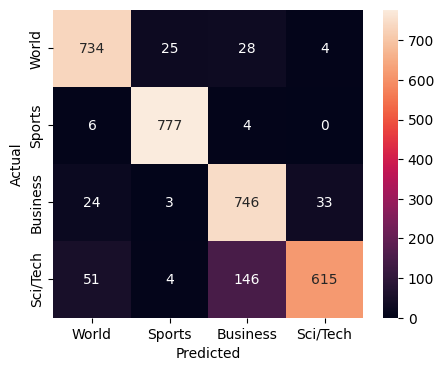

In [77]:
## Plotting the confusion matrix
plot_confusion_matrix(y_train, y_pred_train_flan)

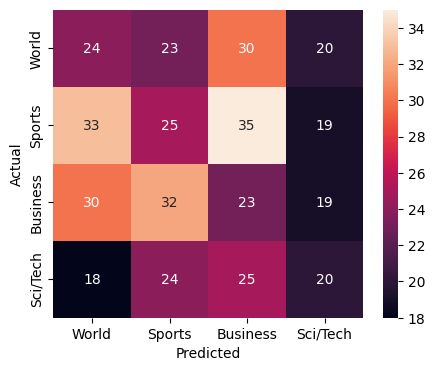

In [78]:
## Complete the code to get the confusion matrix for validation data
plot_confusion_matrix(y_valid, y_pred_valid_flan)

In [79]:
## Getting the classification report for train data
print(classification_report(y_train, y_pred_train_flan))

              precision    recall  f1-score   support

           0       0.90      0.93      0.91       791
           1       0.96      0.99      0.97       787
           2       0.81      0.93      0.86       806
           3       0.94      0.75      0.84       816

    accuracy                           0.90      3200
   macro avg       0.90      0.90      0.90      3200
weighted avg       0.90      0.90      0.90      3200



In [80]:
## Complete the code to get the classification report for validation data
print(classification_report(y_valid, y_pred_valid_flan))

              precision    recall  f1-score   support

           0       0.23      0.25      0.24        97
           1       0.24      0.22      0.23       112
           2       0.20      0.22      0.21       104
           3       0.26      0.23      0.24        87

    accuracy                           0.23       400
   macro avg       0.23      0.23      0.23       400
weighted avg       0.23      0.23      0.23       400



In [81]:
## Storing the metrics
flan_train_base = model_performance_classification(y_pred_train_flan,y_train)
flan_valid_base = model_performance_classification(y_pred_valid_flan,y_valid)

### Improved Prompt for Prediction

In [82]:
# defining a prompt which tells the model what to do
sys_prompt = """
You are a text classifier. Your task is to predict the category of the given news article
into one of the following categories: World, Sports, Business, or Sci/Tech.
Respond only with the category name.
"""

# predicting the sentiment using the model by incorporating the system prompt and the provided review text

pred_sent = generate_response(
    """
        {}
        news article: '{}'
    """.format(sys_prompt, X[4])
)

print(pred_sent)

Business


In [83]:
## Applying predict_category function on the train and validation data
y_pred_train_flan_imp = X_train.apply(predict_category)
y_pred_valid_flan_imp = X_valid.apply(predict_category)

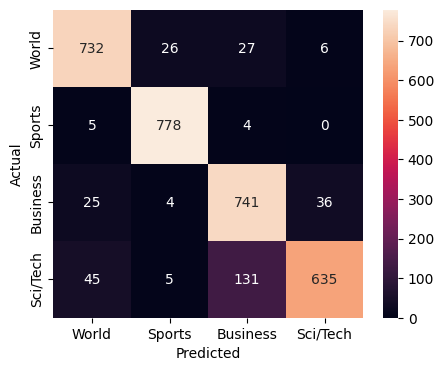

In [84]:
## Plotting the confusion matrix for train data
plot_confusion_matrix(y_train, y_pred_train_flan_imp)

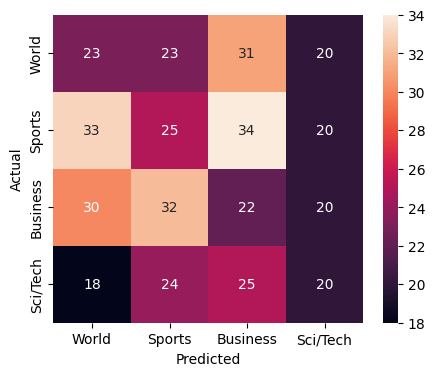

In [85]:
## Complete the code to get the confusion matrix for validation data
plot_confusion_matrix(y_valid, y_pred_valid_flan_imp)

In [86]:
## Getting the classification report for train data
print(classification_report(y_train, y_pred_train_flan_imp))

              precision    recall  f1-score   support

           0       0.91      0.93      0.92       791
           1       0.96      0.99      0.97       787
           2       0.82      0.92      0.87       806
           3       0.94      0.78      0.85       816

    accuracy                           0.90      3200
   macro avg       0.91      0.90      0.90      3200
weighted avg       0.91      0.90      0.90      3200



In [87]:
## Complete the code to get the classification report for validation data
print(classification_report(y_valid, y_pred_valid_flan_imp))

              precision    recall  f1-score   support

           0       0.22      0.24      0.23        97
           1       0.24      0.22      0.23       112
           2       0.20      0.21      0.20       104
           3       0.25      0.23      0.24        87

    accuracy                           0.23       400
   macro avg       0.23      0.23      0.23       400
weighted avg       0.23      0.23      0.23       400



In [88]:
## Storing the metrics
flan_train_imp = model_performance_classification(y_pred_train_flan_imp,y_train)
flan_valid_imp = model_performance_classification(y_pred_valid_flan_imp,y_valid)

## **Model Performance Comparison and Final Model Selection**

In [89]:
## Training performance comparison

models_train_comp_df = pd.concat(
    [
        rf_train_perf.T,
        rf_bal_train_perf.T,
        rf_tuned_train_perf.T,
        flan_train_base.T,
        flan_train_imp.T
    ],
    axis=1,
)
models_train_comp_df.columns = [
    "Random Forest(base)",
    "Random Forest with class_weights",
    "Random Forest(tuned)",
    "Flan (base prompt)",
    "Flan (improvised prompt)"
]
print("Training performance comparison:")
models_train_comp_df

Training performance comparison:


,Random Forest(base),Random Forest with class_weights,Random Forest(tuned),Flan (base prompt),Flan (improvised prompt)
Accuracy,1.0,1.0,0.964063,0.897500,0.901875
Recall,1.0,1.0,0.964063,0.897500,0.901875
Precision,1.0,1.0,0.964217,0.902713,0.905433
F1,1.0,1.0,0.963989,0.896295,0.900966


In [90]:
## Validation set performance comparison
models_valid_comp_df = pd.concat(
    [
        rf_valid_perf.T,
        rf_bal_valid_perf.T,
        rf_tuned_valid_perf.T,
        flan_valid_base.T,
        flan_valid_imp.T
    ],
    axis=1,
)
models_valid_comp_df.columns = [
    "Random Forest(base)",
    "Random Forest with class_weights",
    "Random Forest(tuned)",
    "Flan (base prompt)",
    "Flan (improvised prompt)"
]
print("Validation set performance comparison:")
models_valid_comp_df

Validation set performance comparison:


,Random Forest(base),Random Forest with class_weights,Random Forest(tuned),Flan (base prompt),Flan (improvised prompt)
Accuracy,0.897500,0.905000,0.895000,0.230000,0.225000
Recall,0.897500,0.905000,0.895000,0.230000,0.225000
Precision,0.897553,0.905129,0.895909,0.231426,0.226384
F1,0.897376,0.904941,0.895046,0.230281,0.225371


**Pick the best model from the above table and apply on test data**

In [91]:
## Assigns test rows based on index
X_test = embedding_matrix[y_test.index]

None


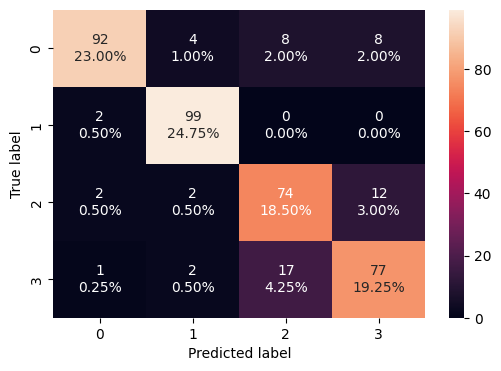

In [92]:
print(confusion_matrix_sklearn(rf_balanced, X_test, y_test))

In [93]:
# Predicting on test data
y_pred_test = rf_balanced.predict(X_test)

In [94]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.95      0.82      0.88       112
           1       0.93      0.98      0.95       101
           2       0.75      0.82      0.78        90
           3       0.79      0.79      0.79        97

    accuracy                           0.85       400
   macro avg       0.85      0.85      0.85       400
weighted avg       0.86      0.85      0.86       400



## **Actionable Insights and Recommendations**

## Actionable Insights and Recommendations

### 1. **Model Selection**:
   - The **Random Forest with Class Weights** model outperformed all other models on the **validation set**.
   - It achieved the highest Accuracy (90.5%), Recall, Precision, and F1-score.

### 2. **Performance Overview**:
   - **Training Set**: The model shows a strong fit with excellent performance across all metrics.
   - **Validation Set**: Performance is consistent, indicating minimal overfitting and good generalization capability.
   - **Flan-based Transformer Models**:
     - These models underperformed significantly, suggesting they are not well-suited for this dataset or task configuration.

### 3. **Recommendations**:
   - **Deploy the Random Forest with Class Weights** model for production/testing on unseen data.
   - **Optimize Model Efficiency**:
     - Reduce computational costs by tuning hyperparameters further or pruning the model.
   - **Data Enhancement**:
     - Collect additional data for better coverage of edge cases.
     - Explore advanced feature engineering to improve model inputs.
   - **Transformer Models**:
     - Revisit transformer models with larger pre-trained variants and fine-tuning strategies to address their poor performance.

### 4. **Future Scope**:
   - Experiment with **ensemble methods** to combine predictions from multiple models.
   - Incorporate **class imbalance techniques** (e.g., SMOTE) for further improvements.
   - Explore the integration of **domain-specific embeddings** for text-based features.

-





---

